In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf
from scipy.stats import bernoulli
from scipy.stats import truncnorm
import math

In [2]:
def DGP(intervene_A=None):
    p = 0.6     # Above, this was defined as 0.5. In paper, it's 0.6
    n = 10000

    # A (gender)
    if intervene_A:
        A2 = np.ones(n)
    else:
        A2 = U_A = bernoulli.rvs(p=p, size=n)


    # Q (qualifications)
    U_Q = np.random.normal(2, 5, n)
    Q2 = np.floor(U_Q)


    # D (number of children)
    lower_d, upper_d = 0.1, 3
    mu_d, sigma_d = 2, 1
    X_d = stats.truncnorm((lower_d - mu_d) / sigma_d, (upper_d - mu_d) / sigma_d, loc=mu_d, scale=sigma_d)
    U_D = X_d.rvs(n)
    D2 = A2 + np.floor(0.5 * Q2 * U_D)


    # M (physical strength)
    lower_m, upper_m = 0.1, 3
    mu_m, sigma_m = 3, 2
    X_m = stats.truncnorm((lower_m - mu_m) / sigma_m, (upper_m - mu_m) / sigma_m, loc=mu_m, scale=sigma_m)
    U_M = X_m.rvs(n)
    M2 = 3*A2 + (0.4 * Q2 * U_M)


    sigmoid = lambda x: 1/(1+ math.exp(-x))

    Y2 = np.zeros(n)
    for i in range(n):
        Y2[i] = sigmoid(-10+5*A2[i]+Q2[i]+D2[i]+M2[i]) >= 0.5


    df = pd.DataFrame({'A': A2, 'D': D2, 'M': M2 ,'Q': Q2,'Y':Y2})
    
    return df

In [3]:
#counterfactual gender
def counterfactual_df(without_intervention):
    n = 10000
    A2 = 1 - without_intervention.A.values

    # Q (qualifications) - unchanged
    Q2 = without_intervention.Q.values


    # D (number of children)
    lower_d, upper_d = 0.1, 3
    mu_d, sigma_d = 2, 1
    X_d = stats.truncnorm((lower_d - mu_d) / sigma_d, (upper_d - mu_d) / sigma_d, loc=mu_d, scale=sigma_d)
    U_D = X_d.rvs(n)
    D2 = A2 + np.floor(0.5 * Q2 * U_D)


    # M (physical strength)
    lower_m, upper_m = 0.1, 3
    mu_m, sigma_m = 3, 2
    X_m = stats.truncnorm((lower_m - mu_m) / sigma_m, (upper_m - mu_m) / sigma_m, loc=mu_m, scale=sigma_m)
    U_M = X_m.rvs(n)
    M2 = 3*A2 + (0.4 * Q2 * U_M)


    sigmoid = lambda x: 1/(1+ math.exp(-x))

    Y2 = np.zeros(n)
    for i in range(n):
        Y2[i] = sigmoid(-10+5*A2[i]+Q2[i]+D2[i]+M2[i]) >= 0.5

    Counterfactual_df = pd.DataFrame({'A': A2, 'D': D2, 'M': M2 ,'Q': Q2,'Y':Y2})
    return Counterfactual_df

In [4]:
#Data Preperation
def data_processing(without_intervention, Counterfactual_df):
    from sklearn.model_selection import train_test_split
    #discretize fair fair Q
    without_intervention['bi_Q'] = np.where(without_intervention['Q'] <= np.quantile(without_intervention['Q'], 0.5), -1, 1)
    Counterfactual_df['bi_Q'] = np.where(Counterfactual_df['Q'] <= np.quantile(Counterfactual_df['Q'], 0.5), -1, 1)
    
    X_train, X_test, y_train, y_test = train_test_split(without_intervention.drop(['Y'], axis = 1), 
                                                        without_intervention.Y,
                                                        test_size = 0.2, 
                                                        stratify = without_intervention.Y)
    #get the same rows of counterfactual test data
    Counter_X_test = Counterfactual_df.drop(['Y'], axis = 1).iloc[X_test.index.values, :]
    Counter_y_test = Counterfactual_df['Y'][X_test.index.values]
    
    return X_train, X_test, y_train, y_test, Counter_X_test, Counter_y_test


In [5]:
#Model training and prediction results:
def trainers(X_train, y_train, full_cols, unaware_cols, fair_var, model):
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.svm import SVC
    
    if model == 'log':
        full = LogisticRegression()
        unaware = LogisticRegression()
        fair = LogisticRegression()
        
        full.fit(X_train[full_cols], y_train)
        unaware.fit(X_train[unaware_cols], y_train)
        fair.fit(X_train[fair_var], y_train)
    
    elif model == 'svm':
        full = SVC()
        unaware = SVC()
        fair = SVC()
        
        full.fit(X_train[full_cols], y_train)
        unaware.fit(X_train[unaware_cols], y_train)
        fair.fit(X_train[fair_var], y_train)
        
        
    elif model == 'dt':
        full = DecisionTreeClassifier()
        unaware = DecisionTreeClassifier()
        fair = DecisionTreeClassifier()
        
        full.fit(X_train[full_cols], y_train)
        unaware.fit(X_train[unaware_cols], y_train)
        fair.fit(X_train[fair_var], y_train)
    
    else:
        dec = 'model is not included in is trainer'
        return dec
    
    return {'full': full, 'unaware': unaware, 'fair': fair}

In [6]:
#get predictions
def get_predictions(X_test, Counter_X_test, full_cols, unaware_cols, fair_var, fitted_models):
    import pandas as pd
    
    predictions = {}
    counter_predictions = {}
    
    for model in fitted_models:
        if model == 'full':
            predictions[model] = fitted_models[model].predict(X_test[full_cols])
            counter_predictions[model] = fitted_models[model].predict(Counter_X_test[full_cols])
        if model == 'unaware':
            predictions[model] = fitted_models[model].predict(X_test[unaware_cols])
            counter_predictions[model] = fitted_models[model].predict(Counter_X_test[unaware_cols])
        if model == 'fair':
            predictions[model] = fitted_models[model].predict(X_test[fair_var])
            counter_predictions[model] = fitted_models[model].predict(Counter_X_test[fair_var])

    return pd.DataFrame(predictions), pd.DataFrame(counter_predictions)

In [7]:
## counterfactual fairness: sum of absulute difference (counter yhat - factual yhat)
def counterfactual_fairness(counter_prediction, factual_prediction):
    return sum(abs(counter_prediction - factual_prediction))/len(counter_prediction)

## ETT fairness: absulute value difference between sum of counter predicted y and fautual predicted y
def ett_fairness(counter_prediction, factual_prediction):
    return abs(sum(factual_prediction)- sum(counter_prediction))/len(X_test)

In [8]:
without_intervention = DGP(intervene_A=None)
Counterfactual_df = counterfactual_df(without_intervention)
X_train, X_test, y_train, y_test, Counter_X_test, Counter_y_test = data_processing(without_intervention, Counterfactual_df)

full_cols = ['A', 'Q', 'D', 'M']
unaware_cols = ['Q', 'D', 'M']
fair_var = ['Q']
model = 'log'

fitted_models = trainers(X_train, y_train, full_cols, unaware_cols, fair_var, model)
pred, counter_pred = get_predictions(X_test, Counter_X_test, full_cols, unaware_cols, fair_var, fitted_models)


# Fairness Evaluation Overall (Combined both A=0 and A=1)

In [9]:
pd.DataFrame({
    'ETT': [
        ett_fairness(pred['full'], counter_pred['full']),
        ett_fairness(pred['unaware'], counter_pred['unaware']),
        ett_fairness(pred['fair'], counter_pred['fair'])
    ],
    'Counterfactual':[
        counterfactual_fairness(pred['full'], counter_pred['full']),
        counterfactual_fairness(pred['unaware'], counter_pred['unaware']),
        counterfactual_fairness(pred['fair'], counter_pred['fair'])
    ],
    'Accuracy':[
        fitted_models['full'].score(X_test[full_cols], y_test),
        fitted_models['unaware'].score(X_test[unaware_cols], y_test),
        fitted_models['fair'].score(X_test[fair_var], y_test)
        
    ]
}, index = ['Full Model', 'Unaware Model', 'Fair Predictor Q'])

,ETT,Counterfactual,Accuracy
Full Model,0.0620,0.2770,0.9955
Unaware Model,0.0495,0.2475,0.9730
Fair Predictor Q,0.0000,0.0000,0.8780


# Fairness Evaluation A = 0

In [10]:
pred['A'] = X_test['A'].values
pred0 = pred[pred['A'] == 0]
pred1 = pred[pred['A'] == 1]
counter_pred['A'] = X_test['A'].values
counter_pred0 = counter_pred[counter_pred['A'] == 0]
counter_pred1 = counter_pred[counter_pred['A'] == 1]

In [11]:
pd.DataFrame({
    'ETT': [
        ett_fairness(pred0['full'], counter_pred0['full']),
        ett_fairness(pred0['unaware'], counter_pred0['unaware']),
        ett_fairness(pred0['fair'], counter_pred0['fair'])
    ],
    'Counterfactual':[
        counterfactual_fairness(pred0['full'], counter_pred0['full']),
        counterfactual_fairness(pred0['unaware'], counter_pred0['unaware']),
        counterfactual_fairness(pred0['fair'], counter_pred0['fair'])
    ],
    'Accuracy':[
        fitted_models['full'].score(X_test[full_cols], y_test),
        fitted_models['unaware'].score(X_test[unaware_cols], y_test),
        fitted_models['fair'].score(X_test[fair_var], y_test)
        
    ]
}, index = ['Full Model', 'Unaware Model', 'Fair Predictor Q'])

,ETT,Counterfactual,Accuracy
Full Model,0.1075,0.268080,0.9955
Unaware Model,0.0990,0.246883,0.9730
Fair Predictor Q,0.0000,0.000000,0.8780


## Probability to Get Hired (Y=1) on Protected Attribute subclass 

In [13]:
n = len(pred)

pd.DataFrame({
    'A=0': [
        len(pred0[pred0['full'] == 1])/n,
        len(pred0[pred0['unaware'] == 1])/n,
        len(pred0[pred0['fair'] == 1])/n
    ],
    'Counterfactual prediction for A = 0':[
        len(counter_pred0[counter_pred0['full'] == 1])/n,
        len(counter_pred0[counter_pred0['unaware'] == 1])/n,
        len(counter_pred0[counter_pred0['fair'] == 1])/n
    ]
}, index = ['Full Model', 'Unaware Model', 'Fair Predictor Q'])

,A=0,Counterfactual prediction for A = 0
Full Model,0.1160,0.2235
Unaware Model,0.1215,0.2205
Fair Predictor Q,0.1935,0.1935


# Stage 2: Law School Dataset

In [171]:
# Law School Dataset

df = pd.read_csv('law_data.csv')

#Preprocessing
df = df.drop(columns = ['Unnamed: 0'])
df = df[df['region_first'] != 'PO']

#One-Hot encode gender
gender_coded = pd.get_dummies(df['sex'])
gender_coded.columns = ['Female', 'Male']
df = pd.concat([df, gender_coded], axis=1)
df = df.drop(columns = ['race', 'sex', 'region_first', 'sander_index'])

X = df.drop(['first_pf'], axis = 1)
y = df['first_pf']

from sklearn.model_selection import train_test_split
law_train, law_test, y_law_train, y_law_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [172]:
#Fair K Model
sense_cols = ['Female', 'Male']
n = len(law_train)
ne = len(law_test)
K = len(sense_cols)

law_train['LSAT'] = law_train['LSAT'].astype(int)
law_test['LSAT'] = law_test['LSAT'].astype(int)

law_stan_data = {
    'N' : n, #number of observations
    'K' : K, #number of attributes
    'a' : np.array(law_train[sense_cols]), #protected variable race and sex
    'ugpa' : np.array(law_train['UGPA']), 
    'lsat' : np.array(law_train['LSAT']),
    'zfya' : np.array(y_law_train)
       }

model= """
data {
  int<lower = 0> N; // number of observations
  int<lower = 0> K; // number of covariates
  matrix[N, K]   a; // sensitive variables
  real           ugpa[N]; // UGPA
  int            lsat[N]; // LSAT
  real           zfya[N]; // ZFYA
  
}

transformed data {
  
 vector[K] zero_K;
 vector[K] one_K;
 
 zero_K = rep_vector(0,K);
 one_K = rep_vector(1,K);

}

parameters {

  vector[N] u;

  real ugpa0;
  real eta_u_ugpa;
  real lsat0;
  real eta_u_lsat;
  real eta_u_zfya;
  
  vector[K] eta_a_ugpa;
  vector[K] eta_a_lsat;
  vector[K] eta_a_zfya;
  
  
  real<lower=0> sigma_g_Sq;
}

transformed parameters  {
 // Population standard deviation (a positive real number)
 real<lower=0> sigma_g;
 // Standard deviation (derived from variance)
 sigma_g = sqrt(sigma_g_Sq);
}

model {
  
  // don't have data about this
  u ~ normal(0, 1);
  
  ugpa0 ~ normal(0, 1);
  eta_u_ugpa ~ normal(0, 1);
  lsat0 ~ normal(0, 1);
  eta_u_lsat ~ normal(0, 1);
  eta_u_zfya ~ normal(0, 1);

  eta_a_ugpa ~ normal(zero_K, one_K);
  eta_a_lsat ~ normal(zero_K, one_K);
  eta_a_zfya ~ normal(zero_K, one_K);

  sigma_g_Sq ~ inv_gamma(1, 1);

  // have data about these
  ugpa ~ normal(ugpa0 + eta_u_ugpa * u + a * eta_a_ugpa, sigma_g);
  lsat ~ poisson(exp(lsat0 + eta_u_lsat * u + a * eta_a_lsat));
  zfya ~ normal(eta_u_zfya * u + a * eta_a_zfya, 1);

}
"""

import stan
import nest_asyncio
nest_asyncio.apply()
#Using STAN package with the model we defined above, this would gives us the posterior distribution knowledge
#We then use the u we learned to generate samples
posterior = stan.build(model, data=law_stan_data, random_seed=1)
fit = posterior.sample(num_chains= 1, num_samples= 50)

U_train = fit['u'].mean(axis = 1)
pd.DataFrame(U_train).to_csv('U_train.csv')

#Get parameters.

ugpa0 = fit['ugpa0'].mean()
eta_u_ugpa = fit['eta_u_ugpa'].mean()
eta_a_ugpa = fit['eta_a_ugpa'].mean(axis = 1)

lsat0 = fit['lsat0'].mean()
eta_u_lsat = fit['eta_u_lsat'].mean()
eta_a_lsat = fit['eta_a_lsat'].mean(axis = 1)

sigma_g = fit['sigma_g'].mean()


#Get estimation for test 

model_u = """
data {
  int<lower = 0> N; // number of observations
  int<lower = 0> K; // number of covariates
  
  matrix[N, K]   a; // sensitive variables
  real           ugpa[N]; // UGPA
  int            lsat[N]; // LSAT
  //real           zfya[N]; // ZFYA
  //int<lower = 0> pass[N]; // PASS
  real           ugpa0;
  real           eta_u_ugpa;
  vector[K]      eta_a_ugpa;
  real           lsat0;
  real           eta_u_lsat;
  vector[K]      eta_a_lsat;
  //real           eta_u_zfya;
  //vector[K]      eta_a_zfya;
  //real           pass0;
  //real           eta_u_pass;
  //vector[K]      eta_a_pass;
  real           sigma_g;
  
 
}


parameters {

  vector[N] u;

}


model {
  
  u ~ normal(0, 1);

  // have data about these
  ugpa ~ normal(ugpa0 + eta_u_ugpa * u + a * eta_a_ugpa, sigma_g); 
  lsat ~ poisson(exp(lsat0 + eta_u_lsat * u + a * eta_a_lsat)); 
  //zfya ~ normal(eta_u_zfya * u + a * eta_a_zfya,1);
  //pass ~ bernoulli_logit(pass0 + eta_u_pass * u + a * eta_a_pass);
  
}
"""

law_stan_test_data = {
    'N' : ne,#number of test data
    'K' : K,#number of protected attributesv
    'a' : np.array(law_test[sense_cols]), #protected variable race and sex
    'ugpa' : np.array(law_test['UGPA']), 
    'lsat' : np.array(law_test['LSAT']),
    #those are learned from training
    'ugpa0' : ugpa0,
    'eta_u_ugpa' : eta_u_ugpa,
    'eta_a_ugpa' : eta_a_ugpa,
    'lsat0' : lsat0, 
    'eta_u_lsat' : eta_u_lsat,
    'eta_a_lsat' : eta_a_lsat,
    'sigma_g' : sigma_g    
}

posterior_test = stan.build(model_u, data=law_stan_test_data, random_seed=1)
fit_test = posterior_test.sample(num_chains= 1, num_samples=50)
U_test = fit_test['u'].mean(axis = 1)

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.010513 seconds
  1000 transitions using 10 leapfrog steps per transition would take 105.13 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.006074 seconds
  1000 transitions using 10 leapfrog steps per transition would take 60.74 seconds.
  Adjust your expectations accordingly!


In [ ]:
def get_predictions_law(X_test, full_cols, unaware_cols, fair_var, fitted_models):
    import pandas as pd
    
    predictions = {}
    #counter_predictions = {}
    
    for model in fitted_models:
        if model == 'full':
            predictions[model] = fitted_models[model].predict(X_test[full_cols])
            #counter_predictions[model] = fitted_models[model].predict(Counter_X_test[full_cols])
        if model == 'unaware':
            predictions[model] = fitted_models[model].predict(X_test[unaware_cols])
            #counter_predictions[model] = fitted_models[model].predict(Counter_X_test[unaware_cols])
        if model == 'fair':
            predictions[model] = fitted_models[model].predict(X_test[fair_var])
            #counter_predictions[model] = fitted_models[model].predict(Counter_X_test[fair_var])
    pred = pd.DataFrame(predictions)
    return pred

In [207]:
law_train.to_csv('law_train.csv')
law_test.to_csv('law_test.csv')

In [204]:
law_train['K'] = U_train
law_test['K'] = U_test

full_cols = ['LSAT', 'UGPA', 'ZFYA', 'Female','Male','K']
unaware_cols = ['LSAT','UGPA','ZFYA', 'K']
fair_var = ['K']
model = 'dt'

law_result = trainers(law_train, y_law_train, full_cols, unaware_cols, fair_var, model)
law_pred = get_predictions_law(law_test, full_cols, unaware_cols, fair_var, law_result)

In [205]:
law_pred['Female'] = law_test['Female']
law_pred_f = law_pred[law_pred['Female'] == 1]
law_pred_m = law_pred[law_pred['Female'] == 0]
law_n = len(law_test)

pd.DataFrame({
    'Female': [
        len(law_pred_f[law_pred_f['full'] == 1])/law_n,
        len(law_pred_f[law_pred_f['unaware']== 1])/law_n,
        len(law_pred_f[law_pred_f['fair'] ==1])/law_n
    ],
    'Male':[
        len(law_pred_m[law_pred_m['full'] == 1])/law_n,
        len(law_pred_m[law_pred_m['unaware'] == 1])/law_n,
        len(law_pred_m[law_pred_m['fair'] ==1])/law_n
    ],
    'Accuracy':[
        law_result['full'].score(law_test[full_cols], y_law_test),
        law_result['unaware'].score(law_test[unaware_cols], y_law_test),
        law_result['fair'].score(law_test[fair_var], y_law_test)
        ]
}, index = ['Full Model', 'Unaware Model', 'Fair Predictor K'])

,Female,Male,Accuracy
Full Model,0.115802,0.152669,0.848401
Unaware Model,0.115343,0.151905,0.845954
Fair Predictor K,0.115649,0.149457,0.813370


# ------------------ Eng of Work ----------------------

# ------------------ Eng of Work ----------------------

## Draft Work

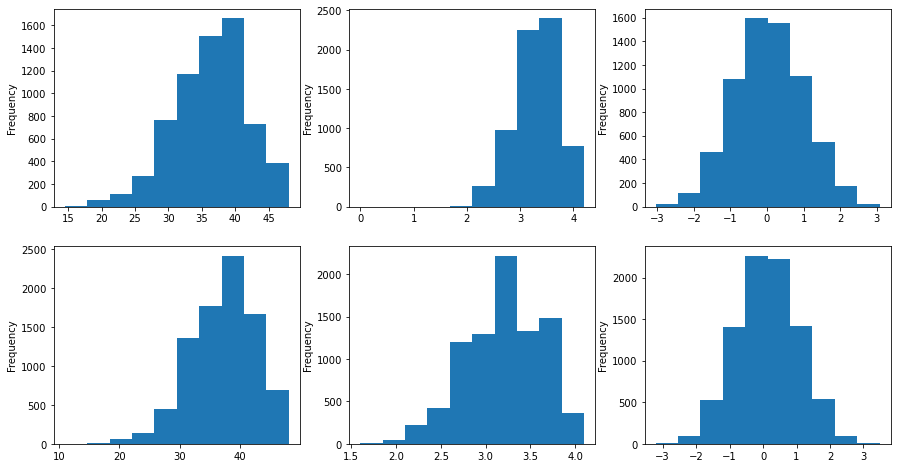

In [63]:
plt.figure(figsize = (15, 8))
plt.subplot(2,3,1)
Xf['LSAT'].plot(kind = 'hist')
plt.subplot(2,3,2)
Xf['UGPA'].plot(kind = 'hist')
plt.subplot(2,3,3)
Xf['ZFYA'].plot(kind = 'hist')
plt.subplot(2,3,4)
Xm['LSAT'].plot(kind = 'hist')
plt.subplot(2,3,5)
Xm['UGPA'].plot(kind = 'hist')
plt.subplot(2,3,6)
Xm['ZFYA'].plot(kind = 'hist')
plt.show()

In [148]:
#Get Counterfactual K
law_stan_counter_data = {
    'N' : ne,
    'K' : K,
    'a' : np.array(Counter_X_test[sense_cols]), #protected variable race and sex
    'ugpa' : np.array(Counter_X_test['UGPA']), 
    'lsat' : np.array(Counter_X_test['LSAT']),
    'ugpa0' : ugpa0,
    'eta_u_ugpa' : eta_u_ugpa,
    'eta_a_ugpa' : eta_a_ugpa,
    'lsat0' : lsat0, 
    'eta_u_lsat' : eta_u_lsat,
    'eta_a_lsat' : eta_a_lsat,
    'sigma_g' : sigma_g    
}

counter_post = stan.build(model_u, data=law_stan_counter_data, random_seed=1)
counter_fit = counter_post.sample(num_chains= 1, num_samples=50)
counter_U = counter_fit['u'].mean(axis = 1)
Counter_X_test['K'] = counter_U

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/1050)
Sampling:  10% (100/1050)
Sampling:  19% (200/1050)
Sampling:  29% (300/1050)
Sampling:  38% (400/1050)
Sampling:  48% (500/1050)
Sampling:  57% (600/1050)
Sampling:  67% (700/1050)
Sampling:  76% (800/1050)
Sampling:  86% (900/1050)
Sampling:  95% (1000/1050)
Sampling:  95% (1001/1050)
Sampling: 100% (1050/1050)
Sampling: 100% (1050/1050), done.
Messages received during sampling:
  Gradient evaluation took 0.002219 seconds
  1000 transitions using 10 leapfrog steps per transition would take 22.19 seconds.
  Adjust your expectations accordingly!


In [109]:
#fitting the distribution on training data and draw conterfactual samples as test data
#len(Xf) = 2860
a, loc, scale = stats.skewnorm.fit(Xm['LSAT']) #draw from LSAT distribution from male
Xtestf['counter_LSAT'] = stats.skewnorm(a, loc, scale).rvs(2860)
a, loc, scale = stats.skewnorm.fit(Xm['UGPA'])
Xtestf['counter_UGPA'] = stats.skewnorm(a, loc, scale).rvs(2860)
mu, sig = stats.norm.fit(Xm['ZFYA'])
Xtestf['counter_ZFYA'] = stats.skewnorm(mu, sig).rvs(2860)
#len(Xm) = 3677
a, loc, scale = stats.skewnorm.fit(Xf['LSAT'])
Xtestm['counter_LSAT'] = stats.skewnorm(a, loc, scale).rvs(3677)
a, loc, scale = stats.skewnorm.fit(Xf['UGPA'])
Xtestm['counter_UGPA'] = stats.skewnorm(a, loc, scale).rvs(3677)
mu, sig = stats.norm.fit(Xf['ZFYA'])
Xtestm['counter_ZFYA'] = stats.skewnorm(mu, sig).rvs(3677)

<ipython-input-109-bd3ad7def80c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtestf['counter_LSAT'] = stats.skewnorm(a, loc, scale).rvs(2860)
<ipython-input-109-bd3ad7def80c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtestf['counter_UGPA'] = stats.skewnorm(a, loc, scale).rvs(2860)
<ipython-input-109-bd3ad7def80c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

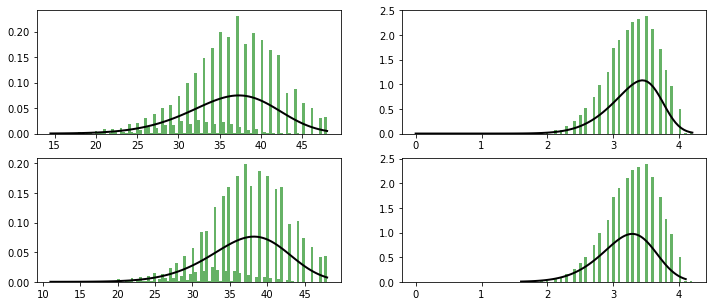

In [85]:
#Generate counterfactual data by drawing samples based on distribution approximation
from scipy import stats
plt.figure(figsize = (12, 5))
plt.subplot(2, 2, 1)
a, loc, scale = stats.skewnorm.fit(Xf['LSAT'])
x = np.linspace(Xf['LSAT'].min(), Xf['LSAT'].max(), 100)
p = stats.skewnorm.pdf(x, a, loc, scale)
plt.plot(x, p, 'k', linewidth=2)
plt.hist(Xf['LSAT'].values, bins=100, density=True, alpha=0.6, color='g')

plt.subplot(2, 2, 2)
a, loc, scale = stats.skewnorm.fit(Xf['UGPA'])
x = np.linspace(Xf['UGPA'].min(), Xf['UGPA'].max(), 100)
p = stats.skewnorm.pdf(x, a, loc, scale)
plt.plot(x, p, 'k', linewidth=2)
plt.hist(Xf['UGPA'].values, bins=100, density=True, alpha=0.6, color='g')

plt.subplot(2, 2, 3)
a, loc, scale = stats.skewnorm.fit(Xm['LSAT'])
x = np.linspace(Xm['LSAT'].min(), Xm['LSAT'].max(), 100)
p = stats.skewnorm.pdf(x, a, loc, scale)
plt.plot(x, p, 'k', linewidth=2)
plt.hist(Xm['LSAT'].values, bins=100, density=True, alpha=0.6, color='g')

plt.subplot(2, 2, 4)
a, loc, scale = stats.skewnorm.fit(Xm['UGPA'])
x = np.linspace(Xm['UGPA'].min(), Xm['UGPA'].max(), 100)
p = stats.skewnorm.pdf(x, a, loc, scale)
plt.plot(x, p, 'k', linewidth=2)
plt.hist(Xf['UGPA'].values, bins=100, density=True, alpha=0.6, color='g')

plt.show()